# Reduce dimension with UMAP or tSNE.  3 features per marker: cytosol, nuclear membrane, nucleus. Style by stim level. Color by timepoint. 

In [1]:
import numpy as np
import pandas as pd
import time
import os
import sys
from tqdm import tqdm, trange
from datetime import date
import nd2reader
from joblib import Parallel, delayed
import tifffile as tf
import xml.etree.ElementTree as ET
import napari
import skimage
from skimage.io import imread
from skimage.measure import block_reduce
from skimage.filters import try_all_threshold
import dask.array as da
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
# from dask_ml.preprocessing import MinMaxScaler
import dask
import matplotlib
import matplotlib.pyplot as plt
import nd2
from skimage import exposure, restoration
from joblib import Parallel, delayed
import torch
from cellpose import models, core, plot
import cv2
import scipy
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from skimage.morphology import closing, square
from skimage.measure import label
import scanpy as sc
import anndata
from anndata import AnnData
import asyncio
from pathlib import Path
from matplotlib.colors import LogNorm

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi = 300)

sns.set(font_scale = 2)
sns.set_style('whitegrid')
np.random.seed(0)

c:\Users\nzhang326\AppData\Local\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


# directories and inputs

In [2]:
# # drugs vs control
# dfPaths = pd.read_excel(Path(r"Y:\coskun-lab\Nicky\48 NFkB gradient on chip\Data\06 Plate 006 static compare\02_plate_drug_vs_ctrl_cycles1-5.xlsx"))
# print(dfPaths)
dataPath = Path.cwd().parent / 'data'
assert dataPath.exists()

# folder to save graph screenshots
# screenshotSavePath = Path(r"Y:\coskun-lab\Nicky\48 NFkB gradient on chip\Data\06 Plate 006 static compare\03 PNG cycles 1-5")
screenshotSavePath = Path.cwd().parent / 'figures'
assert screenshotSavePath.exists()

# identifier columns
idCols = ['Z', 'Y', 'X', 'CellLabel', 'CellRegion', 'Stim', 'FOV', 
          'MaskCytoLabel', 'MaskNucLabel', 'MaskNucMembLabel', 
          'NucCount', 'Cycle', 'NucCytoRatio', 'TimeStamp', 'AntiCorr', 'Drug']

# Read single cell H5

In [3]:
adata = sc.read(dataPath / '01_single_cell_latent_embed.h5')
adata

c:\Users\nzhang326\AppData\Local\anaconda3\Lib\site-packages\anndata\__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
c:\Users\nzhang326\AppData\Local\anaconda3\Lib\site-packages\anndata\_core\anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
c:\Users\nzhang326\AppData\Local\anaconda3\Lib\site-packages\anndata\_core\anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 89665 × 6
    obs: 'Stim', 'TimeStamp', 'P-R', 'P/R', 'FOV', 'Drug'
    uns: 'Palette', 'Stim_sizes', 'neighbors', 'paga', 'pca', 'tsne', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

# Randomly sample n cells within each timepoint (optional)

In [4]:
# adata = sc.read(r"Y:\coskun-lab\Nicky\29 NFkB cells RNA and protein\Data\05 P4 p65 stim TNFa 0,10,20,30,50 mins\01 PKL single cell\single_cell.h5")

# # reset index
# adata.obs.reset_index(drop = True, inplace = True)

# # randomly sample within each timepoint
# randomSub = adata.obs.groupby(['TimeStamp']).sample(n = 100)
# idx = randomSub.index.tolist()
# subData = subData[idx, :] # choose random indices
# subData

# Use scanpy to try UMAP, tSNE, PCA, etc.

In [5]:
def saveFigLabelTime(fig, title): # save figure with current time as label
    # now = datetime.now()
    # now = now.strftime('%d%b%Y_%H%M%S')
    fileOut = title + '.png'
    fileOut = Path(screenshotSavePath, fileOut)
    plt.savefig(fileOut, dpi = 'figure', bbox_inches = 'tight', pad_inches = 0)

    plt.show()

    # wait so figures do not overwrite each other
    time.sleep(2)
    
    return None

# Make time continuous for color scale

In [6]:
adata.obs['TimeStamp'] = adata.obs['TimeStamp'].astype(int) # Make time continuous
# subData.obs['TimeStamp'] = pd.Categorical(subData.obs['TimeStamp']) # Make time discrete

# UMAP

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:29)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:28)


c:\Users\nzhang326\AppData\Local\anaconda3\Lib\site-packages\scanpy\plotting\_utils.py:431: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
c:\Users\nzhang326\AppData\Local\anaconda3\Lib\site-packages\anndata\_core\anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\nzhang326\AppData\Local\anaconda3\Lib\site-packages\anndata\_core\anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\nzhang326\AppData\Local\anaconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


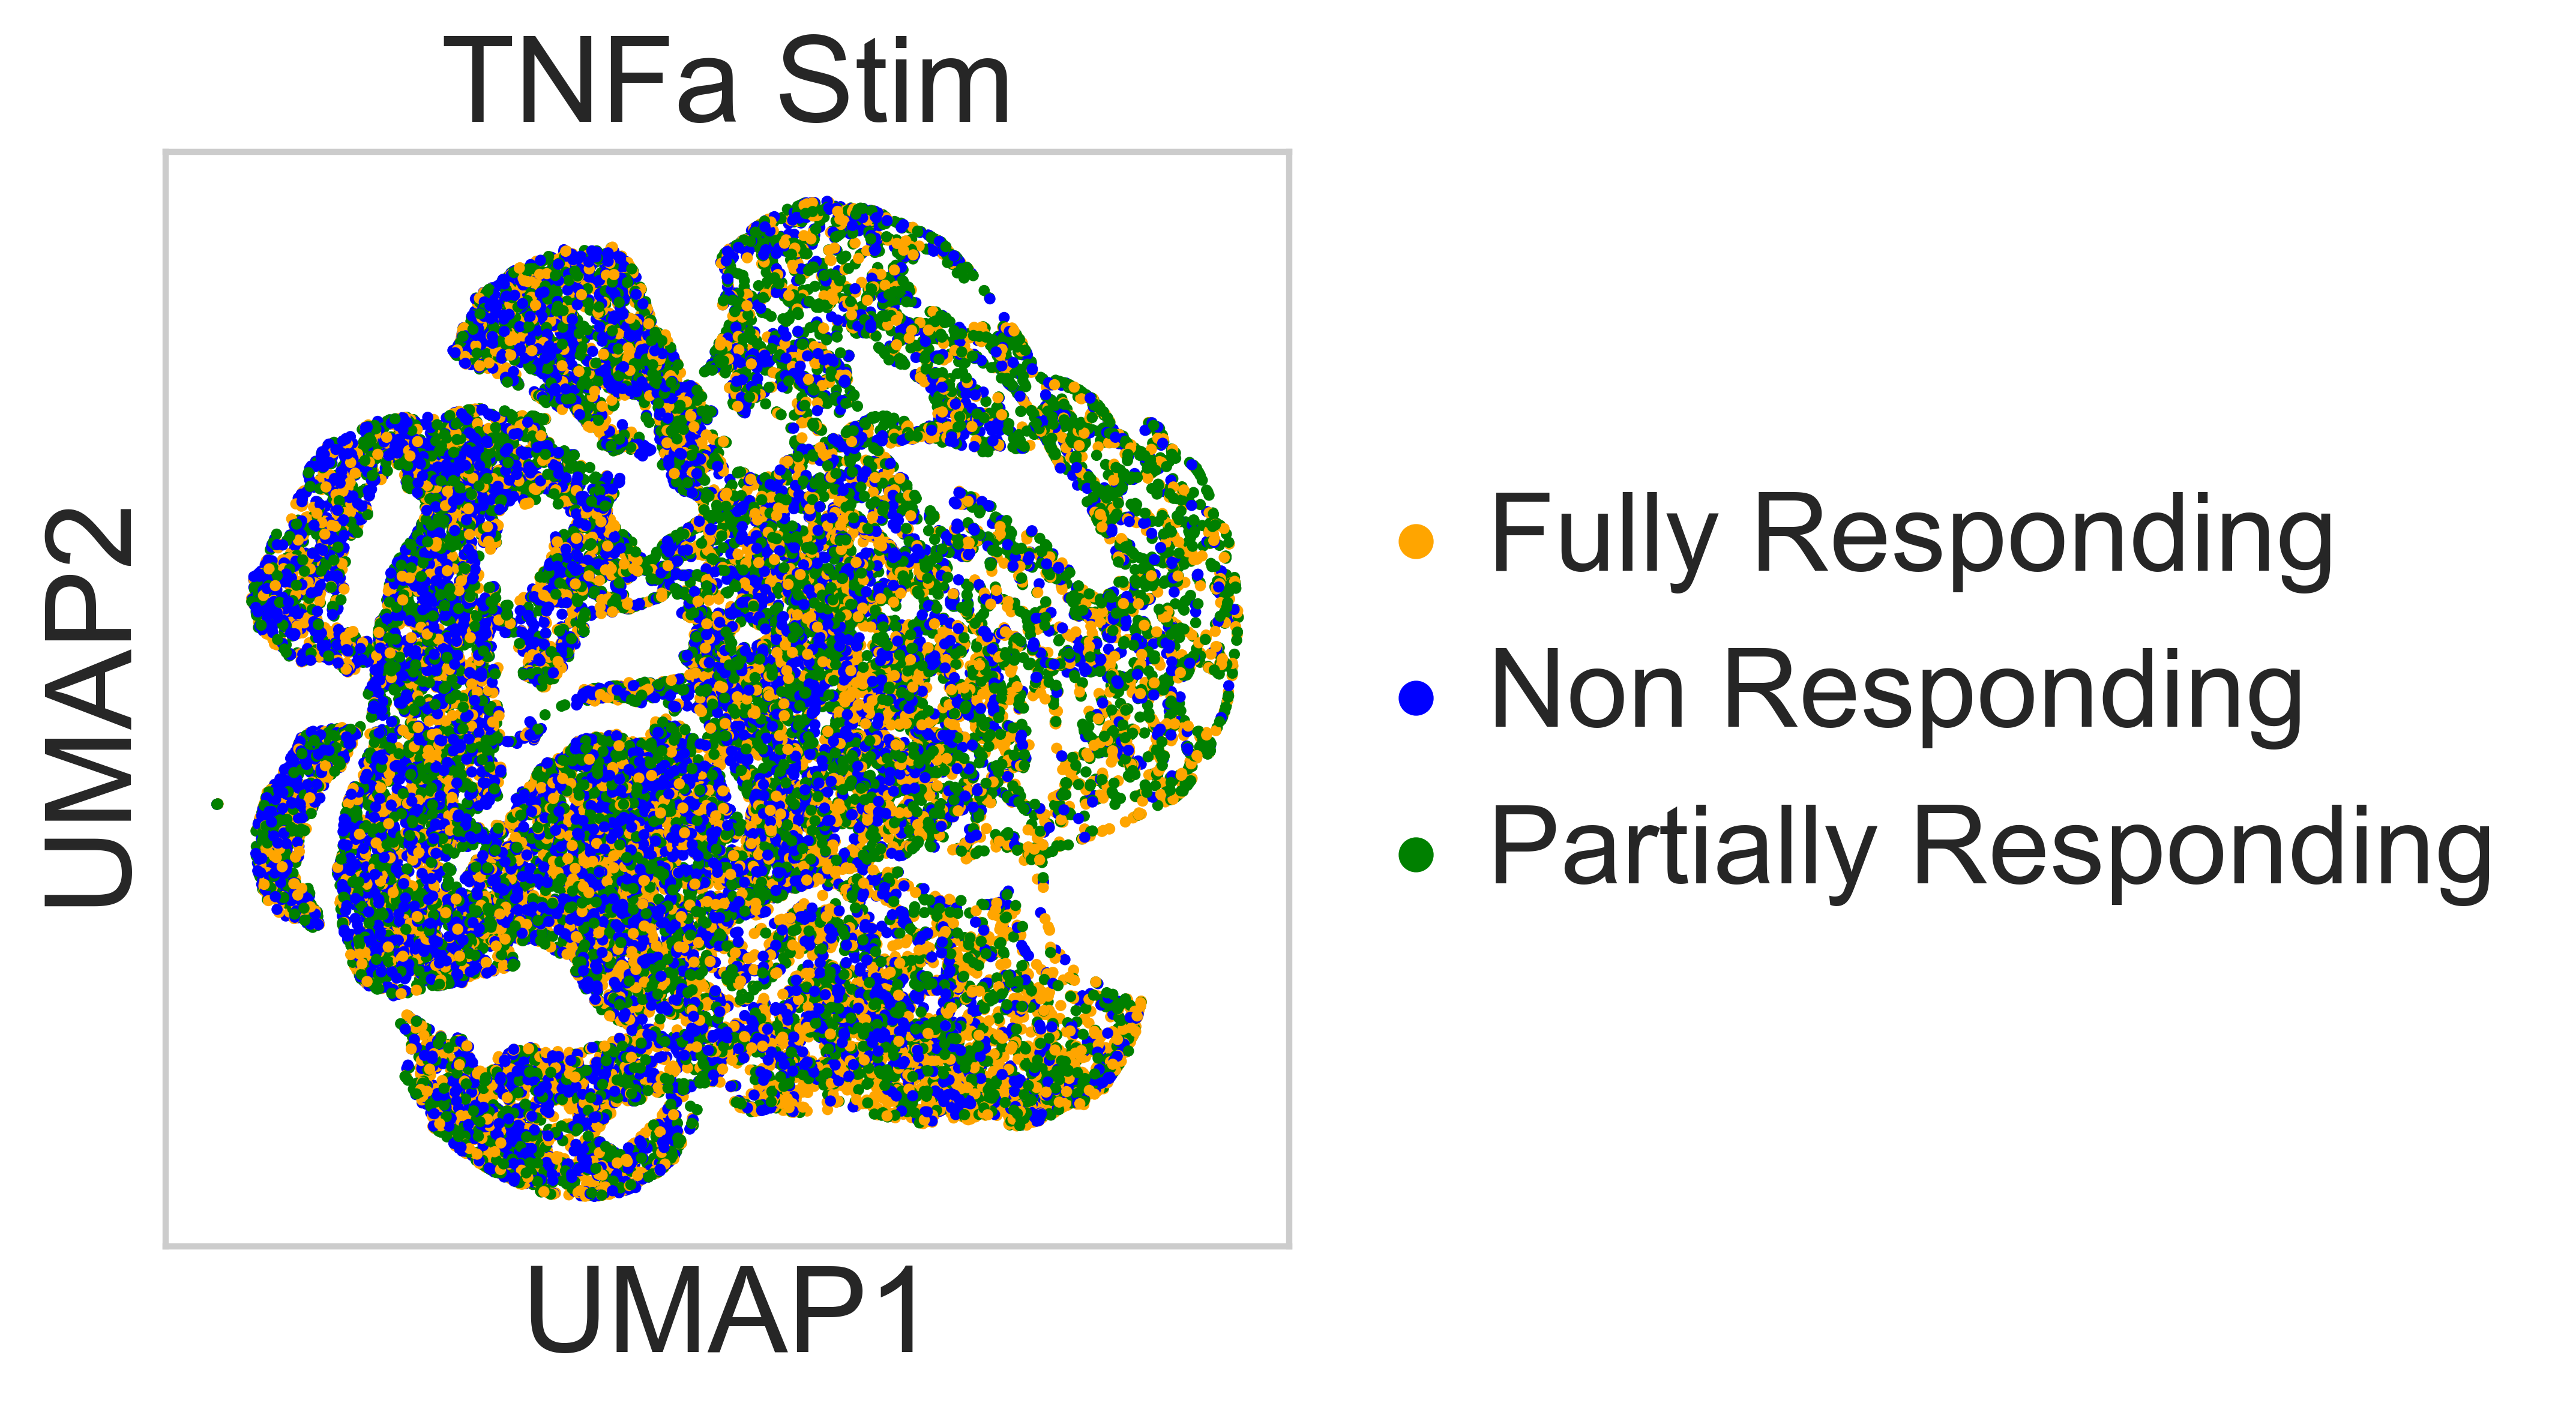

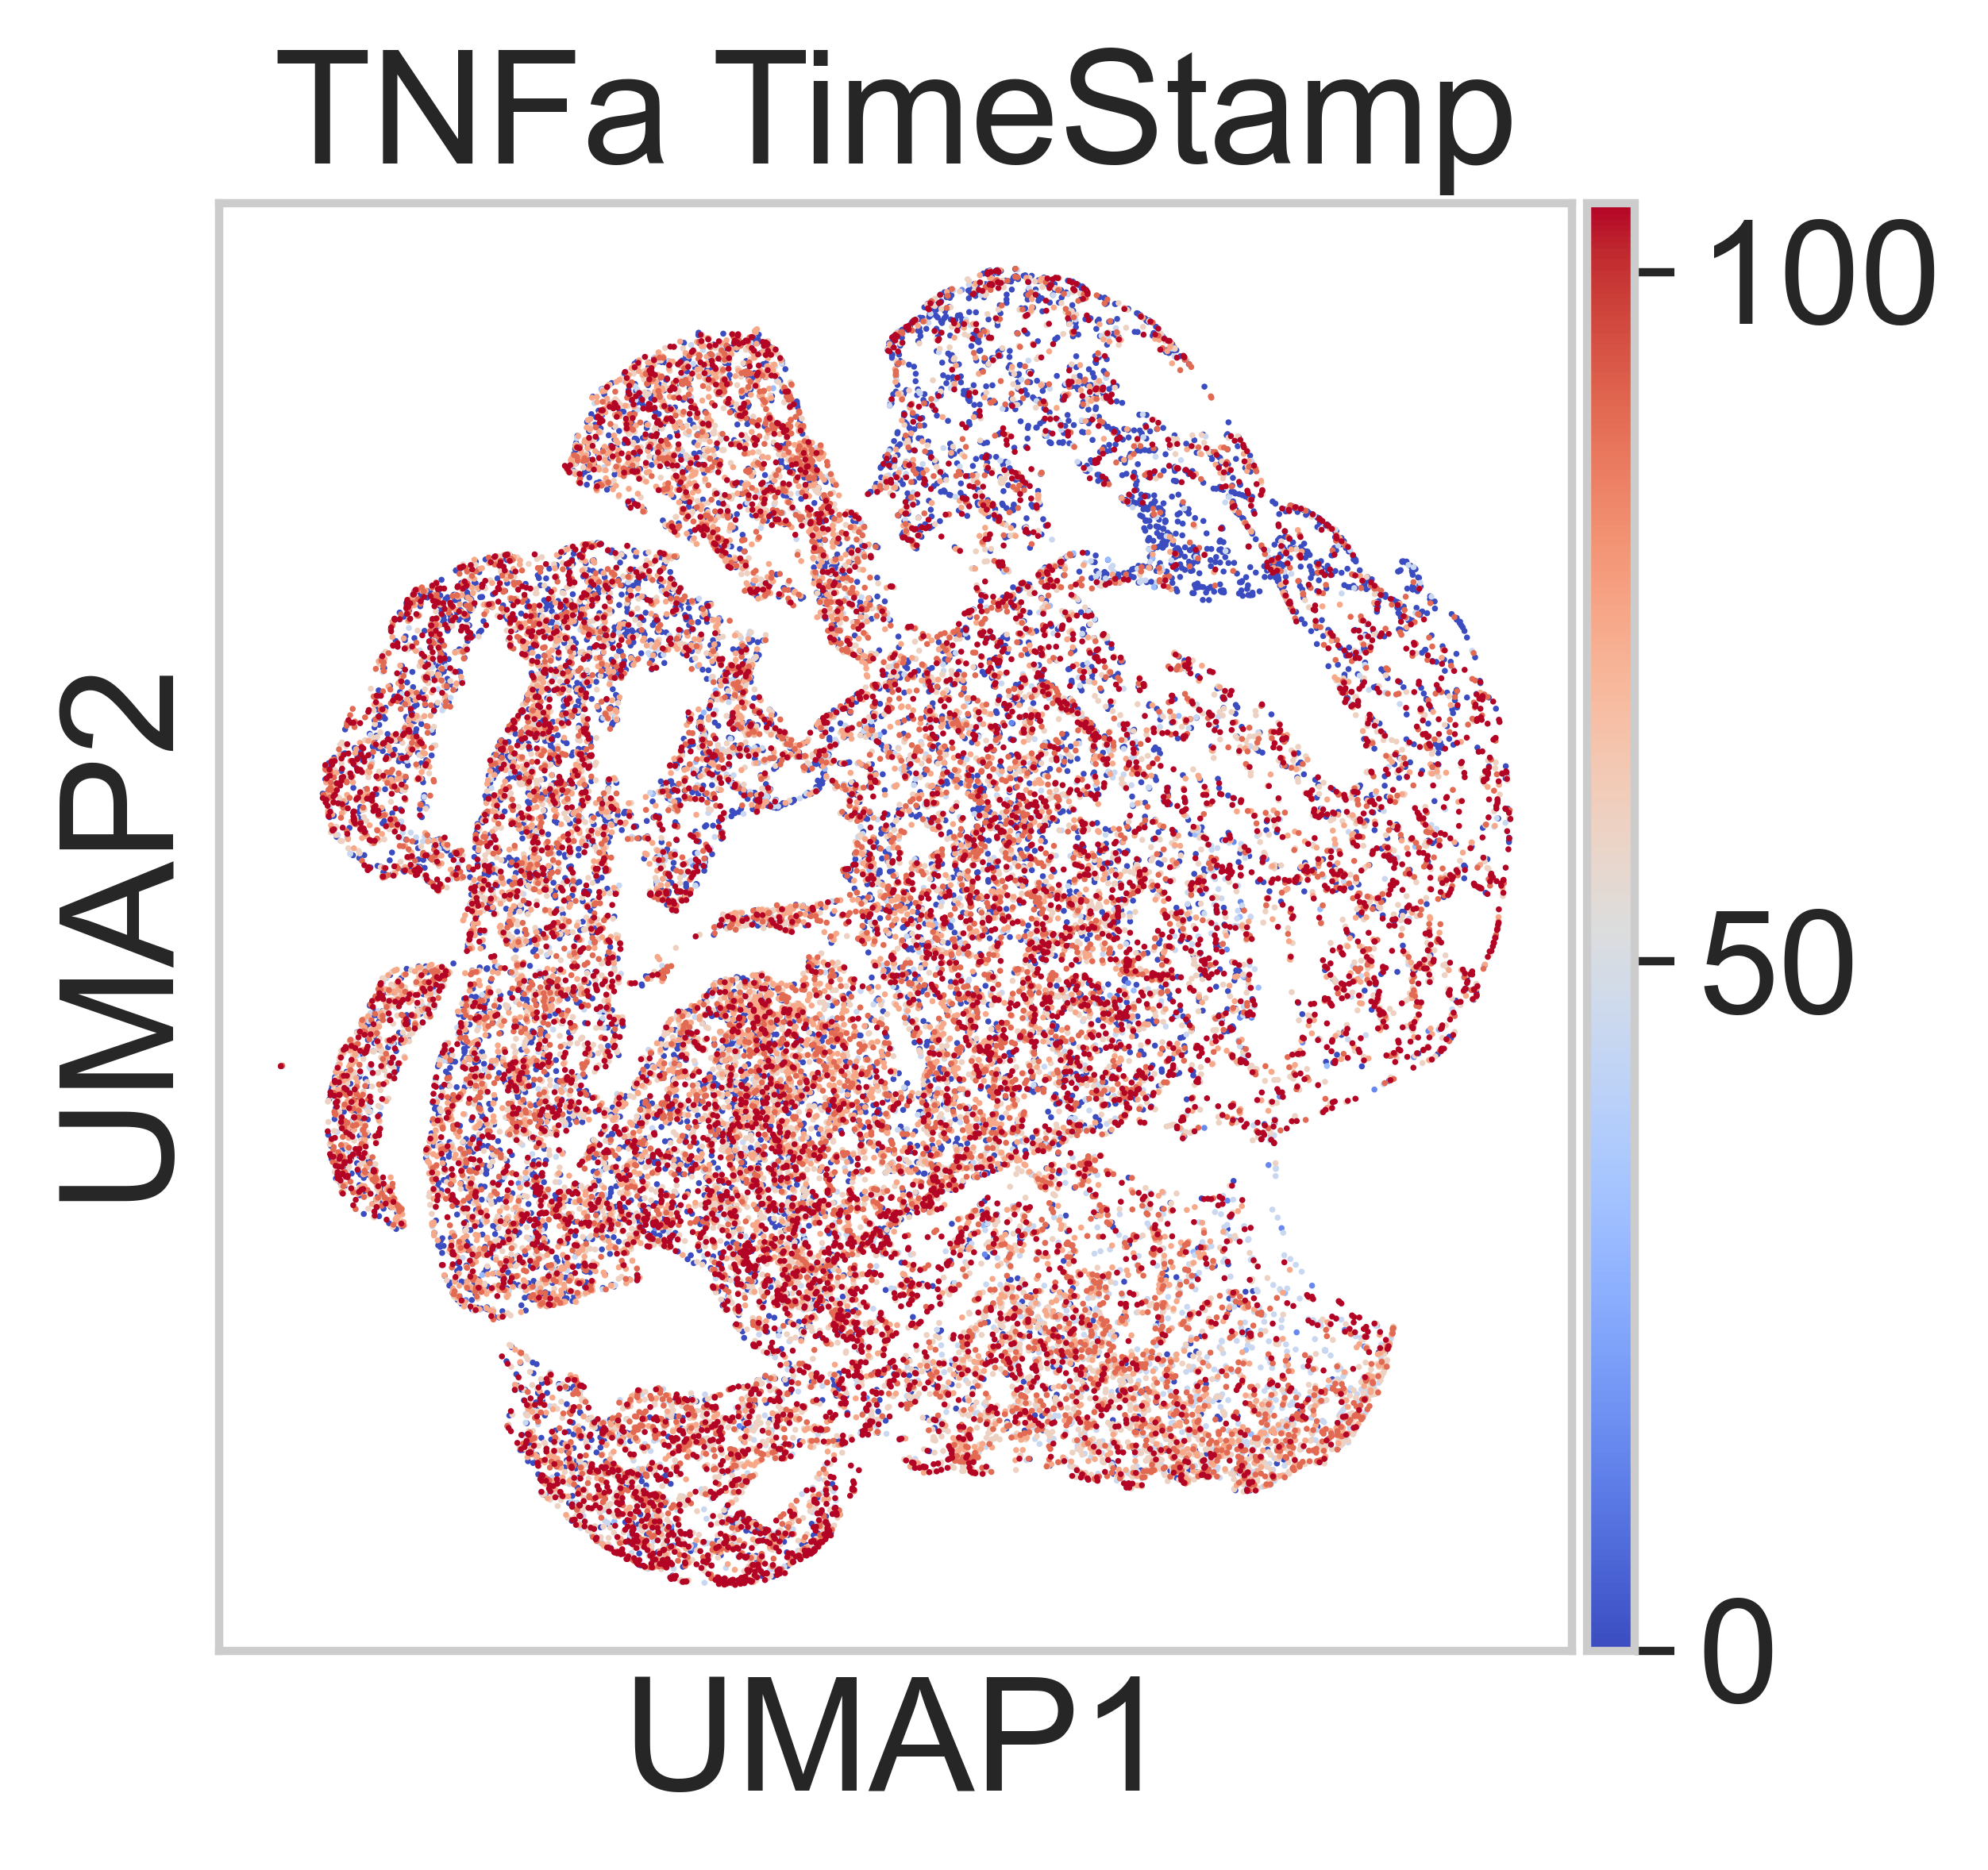

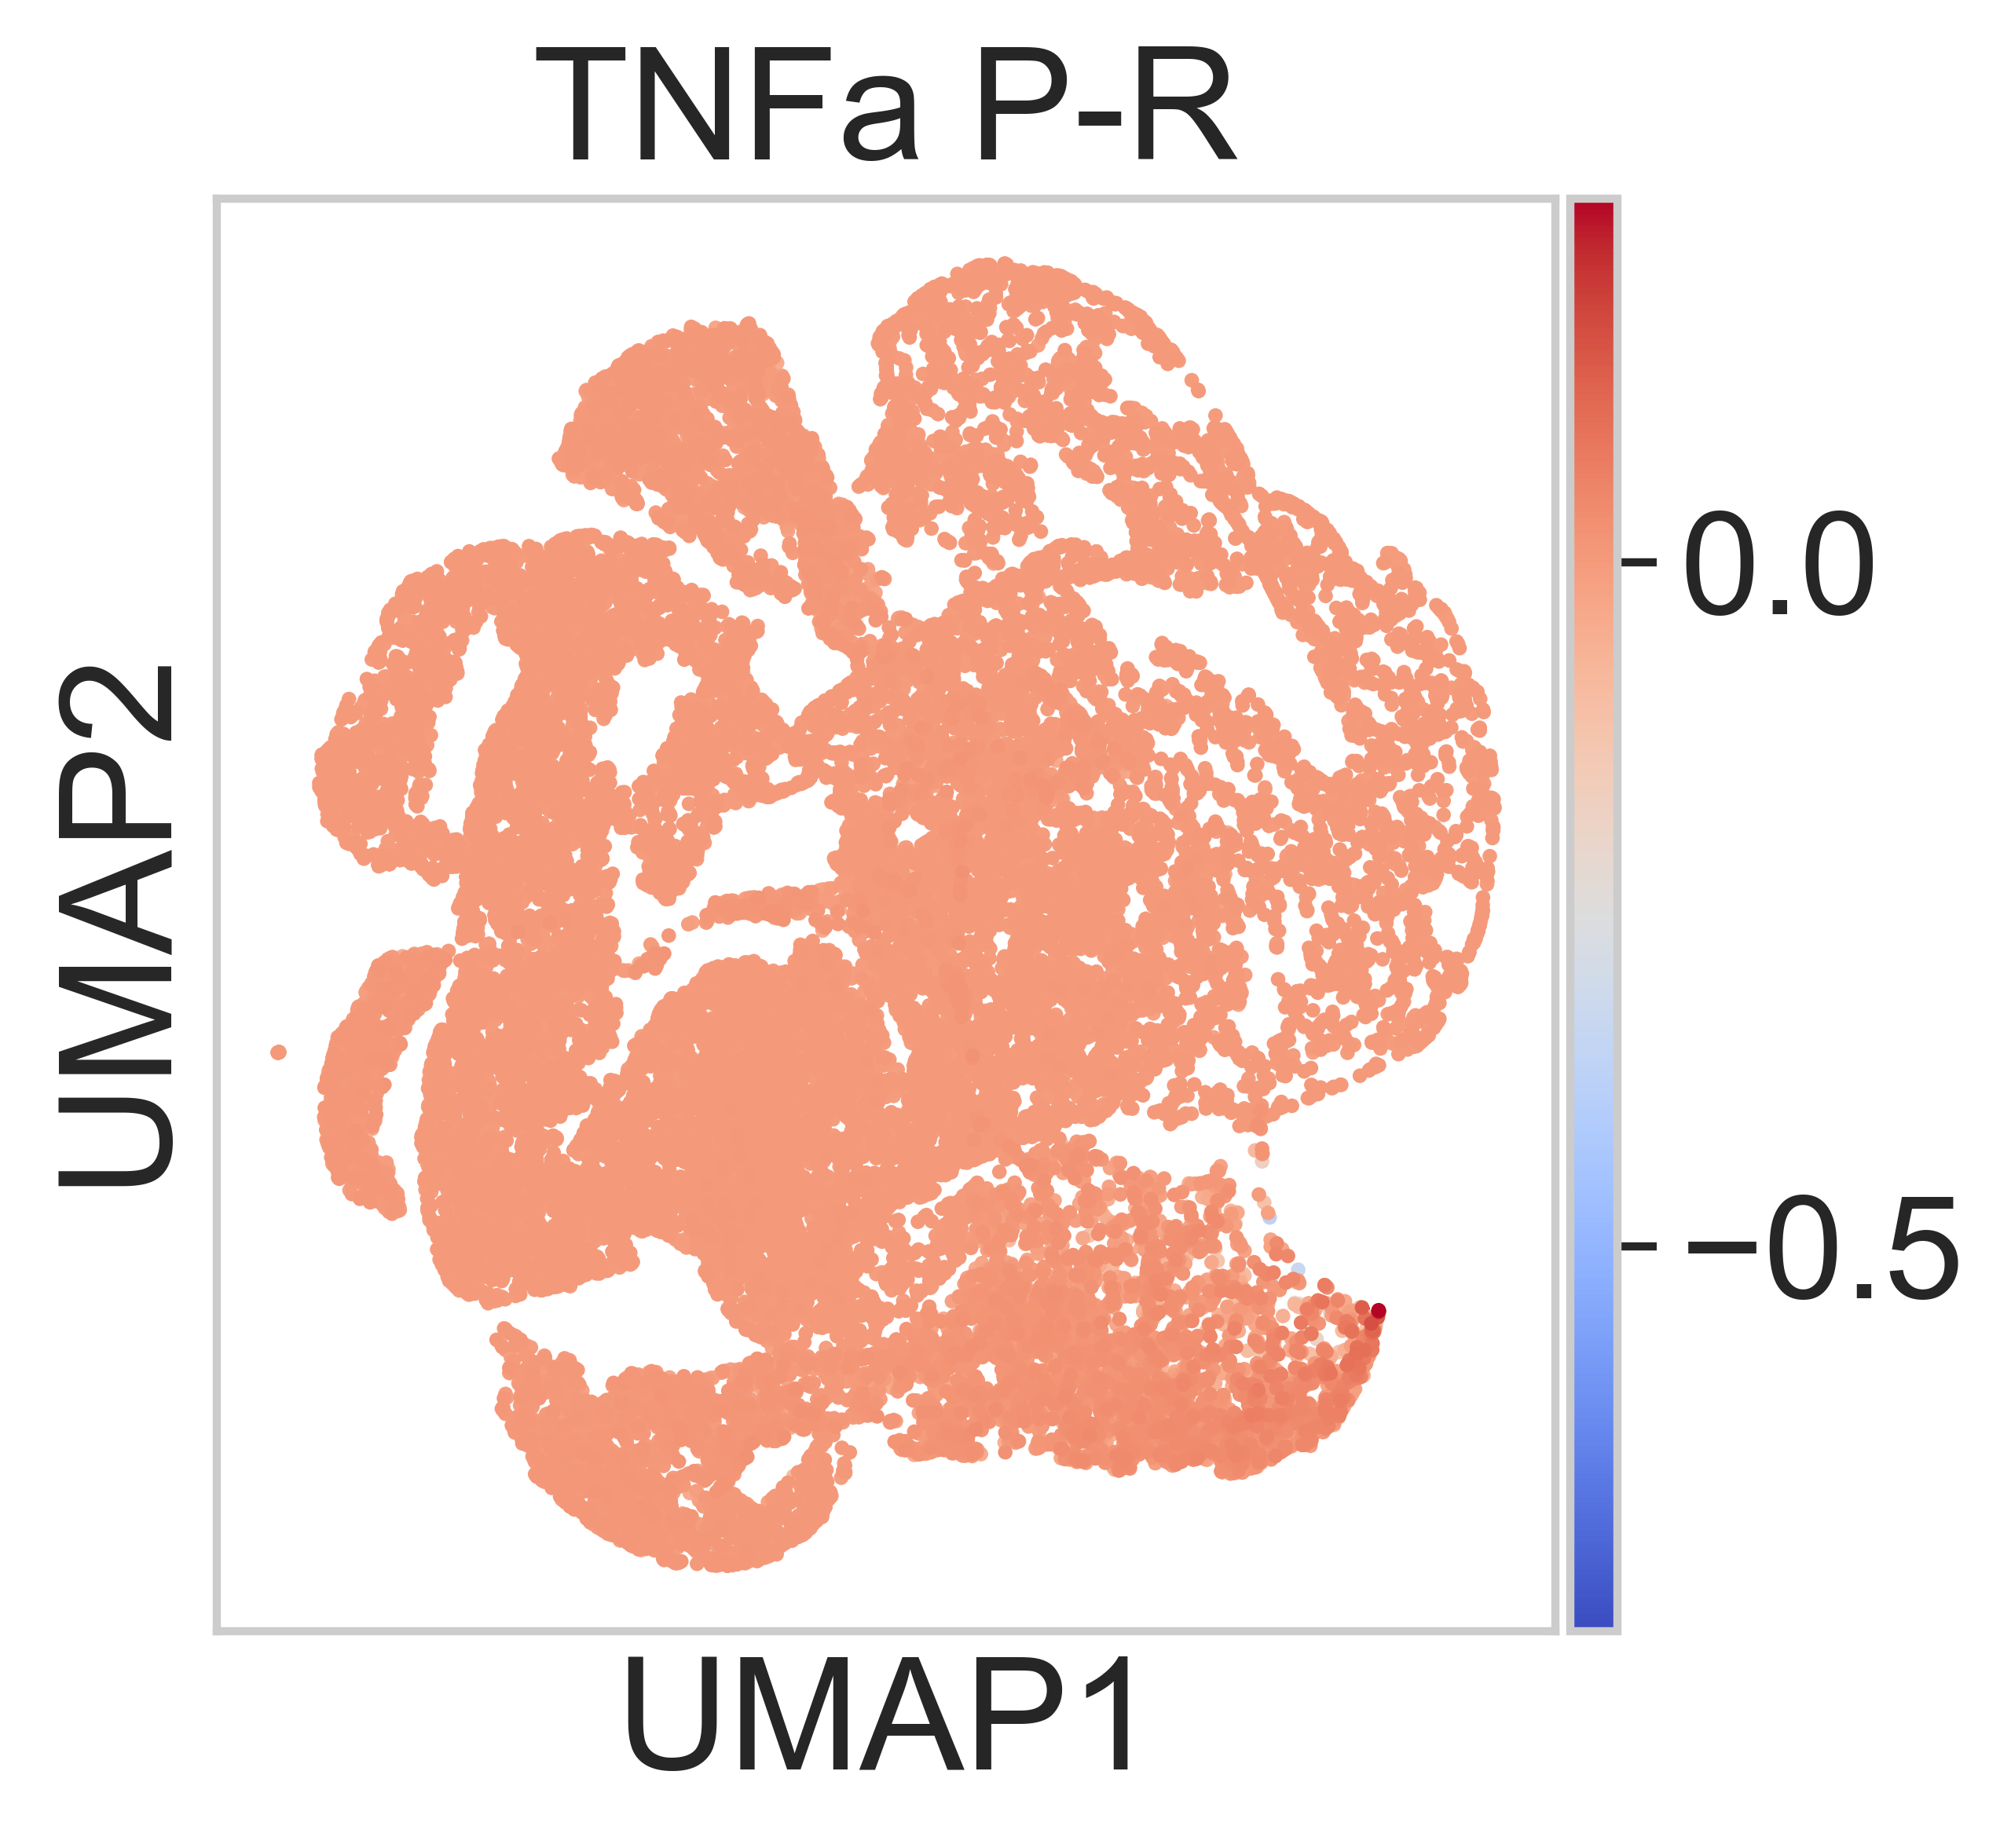

CPU times: total: 50.7 s
Wall time: 1min 7s


In [7]:
%%time 

# regular umap
sc.pp.neighbors(adata, n_neighbors=10, use_rep='X', method='umap')
sc.tl.paga(adata, groups = 'Stim')
sc.pl.paga(adata, plot = False)
sc.tl.umap(adata, random_state = 42, min_dist = 0.1, init_pos = 'paga')

# separate TNFa drug
drug = 'TNFa'
subData = adata[adata.obs['Drug'] == drug]

# color by stim and time
fig = sc.pl.umap(subData, color = 'Stim', size = 20, palette = subData.uns['Palette'], return_fig = True)
plt.title(drug + ' Stim')
saveFigLabelTime(fig, title = 'TNFa_stim')
fig = sc.pl.umap(subData, color = 'TimeStamp', cmap = 'coolwarm', return_fig = True)
plt.title(drug + ' TimeStamp')
saveFigLabelTime(fig, title = 'TNFa_time')

# linear translation difference
fig = sc.pl.umap(subData, color = 'P-R', size = 20, return_fig = True, cmap = 'coolwarm')
plt.title(drug + ' P-R')
saveFigLabelTime(fig, 'TNFa_P-R')